In [1]:
import os
import librosa
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchaudio
import torchvision
import torchaudio.transforms as T
import torch.optim as optim
import glob
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import statistics
import torch.optim as optim
import torchaudio.transforms as T
from torch.utils.data import Dataset
from torchvision import transforms 
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from torch.utils.data.dataset import Subset

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2880000
tensor([[-0.6644, -0.6488, -0.6342,  ..., -0.4985, -0.4861, -0.4733]])
torch.Size([1, 224, 593])
(224, 593)


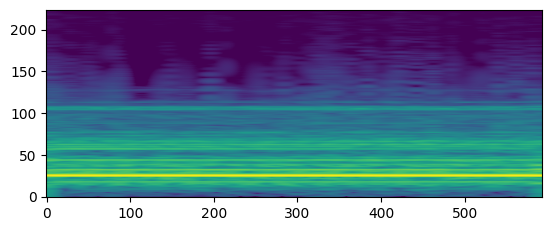

In [9]:


# WAV ファイルの読み込み
SAMPLE_WAV_PATH = "M2RB_T1.wav"
waveform, sample_rate = torchaudio.load(filepath=SAMPLE_WAV_PATH)
print(sample_rate*60)
#start_point = sample_rate * 5
#cut_width = sample_rate * 10
#waveform = waveform[:, start_point : (start_point + cut_width)]
waveform = waveform[:, 0 : sample_rate * 1]
#-----
#new_sample_rate = sample_rate / 2
#channel=0
#waveform_transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform[channel,:].view(1,-1))
print(waveform)
#-----

# Melspectrogram の設定
sample_rate=sample_rate
n_mels = 224#128
n_fft = 4096#2150 #2048
win_length = None
hop_length = n_fft//50 #4
window_fn = torch.hann_window

# Melspectrogram の計算
spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    n_mels=n_mels,
    win_length=win_length,
    hop_length=hop_length,
    window_fn=window_fn,
    power=2.0,
)
spec = spectrogram(waveform)
print(spec.shape)
#spec = spectrogram(waveform)
#spec_aug = torch.nn.Sequential(
#    T.TimeMasking(time_mask_param=30, p=0.1),
#    T.FrequencyMasking(freq_mask_param=30),
#)
#spec = spec_aug(spec)
#print(type(spec))
# 縦軸をデシベルに変換
'''
transform = transforms.FiveCrop(size=(224, 224))
transed_x = transform(spec)
print(transed_x[0].shape)
'''
spec_db = librosa.power_to_db(spec[0])#spec[0])
print(spec_db.shape)

plt.imshow(spec_db, origin="lower")
#plt.savefig("1.png", bbox_inches='tight', pad_inches=0)

torch.Size([1, 2880000]) tensor(-1.) tensor(1.0000)


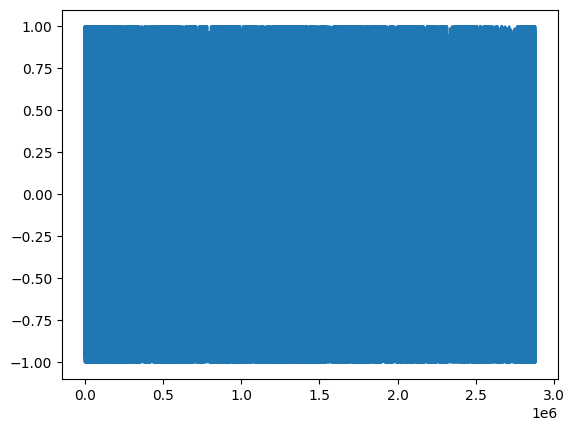

In [82]:
#print(waveform_transformed.shape, waveform_transformed.min(), waveform_transformed.max())
#plt.plot(waveform_transformed[0,:].numpy())
print(waveform.shape, waveform.min(), waveform.max())
plt.plot(waveform[0,:].numpy())

In [ ]:
'''
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])
tensor_transfomed = transform(spec_db)
print(tensor_transfomed.shape)
'''

### 音声のパスのリストを取得

In [ ]:
def get_wav_path_list(ROOT_PATH):
    wild_card_path = os.path.join(ROOT_PATH, "ALL_each_one", "**/*.wav")
    path_list = glob.glob(wild_card_path)
    return path_list

In [ ]:
ROOT_PATH = "./data/Motor_sound"
all_path_list = get_wav_path_list(ROOT_PATH)
print(len(all_path_list))

### Dataset

In [ ]:
class MotorDataset(Dataset):
    def __init__(self, wav_path_list, transform=None, phase="train"):
        self.wav_path_list = wav_path_list
        self.transform = transform
        self.phase = phase
        
        #---メルスペクトログラムを計算しデータとラベルを準備--------------------
        
        self.data = [] # スペクトログラム計算後のテンソルデータを格納する
        self.labels = [] # ラベルを格納する
        for wav_path in self.wav_path_list:
            waveform, sample_rate = torchaudio.load(filepath=wav_path)
            start_point = sample_rate * 5
            cut_width = sample_rate * 10
            waveform = waveform[:, start_point : (start_point + cut_width)]
            
            #-----
            new_sample_rate = sample_rate / 2
            channel=0
            waveform_transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform[channel,:].view(1,-1))

            #-----

            # Melspectrogram の設定
            sample_rate=sample_rate
            n_mels = 224 #128
            n_fft = 2150 #2048
            win_length = None
            hop_length = n_fft//2 #4
            window_fn = torch.hann_window

            # Melspectrogram の計算
            spectrogram = T.MelSpectrogram(
                sample_rate=sample_rate,
                n_fft=n_fft,
                n_mels=n_mels,
                win_length=win_length,
                hop_length=hop_length,
                window_fn=window_fn,
                power=2.0,
            )
            spec = spectrogram(waveform_transformed)
            # 縦軸をデシベルに変換
            # 出力は ndarray : (H,W)  (40, 938)
            spec_db = librosa.power_to_db(spec[0]) 
            
            # データの取得
            self.data.append(spec_db)
            
            # labelの取得
            # フォルダ名から抽出 normal:0, abnormal:1
            label_names = ["normal", "abnormal"]
            for i, name in enumerate(label_names):
                if name in wav_path:
                    label = i
            self.labels.append(label)
        print(len(self.data), len(self.labels))
        
        #-----------------------------------------------------------------
    def __len__(self):
        return len(self.wav_path_list)
    
    def __getitem__(self, index):
        # numpyの(H,W) を (H,W,C)  (40, 938, 1) に変換
        data = self.data[index]
        data = self.min_max(data)
        data = data[:, :, np.newaxis] # 次元の追加
        data_transformed = self.transform(data) # (H,W,C) →　(C,H,W)
        #max_pixel = data_transformed.max
        #min_pixel = data_transformed.min
        #data_transformed = (data_transformed-min_pixel)/(max_pixel-min_pixel)
        return data_transformed, self.labels[index]
    
    # min-max normalization
    def min_max(self, data):
        min = data.min(axis=None, keepdims=True)
        max = data.max(axis=None, keepdims=True)
        data_normalized = (data-min)/(max-min)
        return data_normalized
            
   
        

In [ ]:
transforms = transforms.ToTensor() # (H,W,C) → (C,H,W) の [0.0, 1.0] 

In [ ]:
dataset = MotorDataset(all_path_list, transform=transforms, phase="train")


In [ ]:
print(dataset.__getitem__(0)[0].shape)
print(dataset.__getitem__(0)[1])
print(dataset.__getitem__(0)[0])
print(dataset.data[0].min)

### Dataloader

In [ ]:
import torchvision.models as models
from torchvision.models import resnet34,resnet50,alexnet,vgg16,densenet161,mobilenet_v2
def load_model():
    
    # Resnet34
    resnet34_model = resnet34(pretrained=True)
    #resnet50 = resnet50(pretrained=True)
    # 最初の畳み込みのチャネル3をチャネル1に変更する
    resnet34_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    # 最後の層の次元を今回のカテゴリ数に変更する
    resnet34_model.fc = nn.Linear(512,2)
    
    # Resnet50
    resnet50_model = resnet50(pretrained=True)
    resnet50_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    resnet50_model.fc = nn.Linear(2048,2)
    
    # Alexnet
    alexnet_model = alexnet(pretrained=True)
    alexnet_model.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    alexnet_model.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)
    
    # VGG16
    vgg16_model = vgg16(pretrained=True)
    vgg16_model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    vgg16_model.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)
    
    
    # densenet161
    densenet161_model = densenet161(pretrained=True)
    densenet161_model.features.conv0 = nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    densenet161_model.classifier = nn.Linear(in_features=2208, out_features=2, bias=True)
    
    # MobileNet
    mobilenet_model = mobilenet_v2(pretrained=True)
    mobilenet_model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    mobilenet_model.classifier[1] = nn.Linear(in_features=1280, out_features=2, bias=True)
    
    models = {
        "resnet34": resnet34_model,
        "resnet50": resnet50_model,
        "Alexnet": alexnet_model,
        "VGG16": vgg16_model,
        "densenet": densenet161_model,
        "MobileNet": mobilenet_model   
    }
    
    return models

def trial_model(trial):
   
    resnet34_model = load_model()["resnet34"]
    resnet50_model = load_model()["resnet50"]
    alexnet_model = load_model()["Alexnet"]
    vgg16_model = load_model()["VGG16"]
    densenet161_model = load_model()["densenet"]
    mobilenet_model = load_model()["MobileNet"]
    
    
    model_names = ['resnet34', 'resnet50', 'Alexnet', 'VGG16'] #, 'densenet', 'MobileNet']
    model = trial.suggest_categorical('model', model_names)
    
    if model == model_names[0]:
        model = resnet34_model
    elif model == model_names[1]:
        model = resnet50_model
    elif model == model_names[2]:
        model = alexnet_model
    elif model == model_names[3]:
        model = vgg16_model
    elif model == model_names[4]:
        model = densenet161_model
    elif model == model_names[5]:
        model = mobilenet_model
        
    return model

# 最適化手法の試行
def trial_optimizer(trial, model):
    optimizer_names = ['Adam', 'MomentumSGD', 'rmsprop']
    optimizer_name = trial.suggest_categorical('optimizer', optimizer_names)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)

    if optimizer_name == optimizer_names[0]:
        
        adam_lr = trial.suggest_loguniform('adam_lr', 1e-5, 1e-2)
        optimizer = optim.Adam(model.parameters(), lr=adam_lr, weight_decay=weight_decay)
    elif optimizer_name == optimizer_names[1]:
        momentum_sgd_lr = trial.suggest_loguniform('momentum_sgd_lr', 1e-5, 1e-2)
        optimizer = optim.SGD(model.parameters(), lr=momentum_sgd_lr, momentum=0.9, weight_decay=weight_decay)
    else:
        optimizer = optim.RMSprop(model.parameters())
        
    return optimizer
    

### Optuma ハイパーパラメータ探索

In [ ]:
def train(device, model, train_dataloader, optimizer, criterion, num_epochs) -> None:
    model.train()
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        
        epoch_loss = 0.0
        epoch_acc = 0.0

        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            pred = torch.argmax(outputs, dim=1)
            loss.backward()
            optimizer.step()

            # 損失と正答率 × batch数
            epoch_loss += loss.item()
            epoch_acc += torch.mean(pred.eq(labels).float()) # .eq はboolを返すためfloat()で数値に変換
        # batch数で割る
        epoch_loss /= len(train_dataloader)
        epoch_acc /= len(train_dataloader)

        epoch_acc = epoch_acc.cpu()
        #print(epoch_acc)

        print("{} Loss: {:.4f}, {} accuracy: {:.4f}".format("train", epoch_loss, "train", epoch_acc))


In [ ]:
def test(device, model, test_dataloader):
    model.eval()
    corrects = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            corrects += torch.sum(preds==labels.data)
    accuracy = (corrects / len(test_dataloader.dataset)).item()
    print("test accuracy : {}".format(accuracy))
    return accuracy

In [ ]:
def objective(trial):
    
    # params ---------------------------------------------------------
    fold_accs = [] # 各foldのaccを格納するリスト
    batch_size = 8 # バッチサイズ
    n_splits = 10
    kf = KFold(n_splits, shuffle=True) # n_fold の指定
    num_epochs = 100 # 学習エポック数
    device = "cuda:0" if torch.cuda.is_available() else "cpu" # device の指定
    #------------------------------------------------------------------
    
    # K-fold closs validation
    for _fold, (trainval_index, test_index) in enumerate(kf.split(dataset)): # kf.split で 各fold に分割
        print("{}/{} fold Start!!------------------------------------".format(_fold+1, n_splits))
        # index
        #train_size = int(len(trainval_index) * 0.8)
        #train_index = trainval_index[:train_size]
        #val_index = trainval_index[train_size:]
        
        # dataset
        train_dataset = Subset(dataset, trainval_index)
        #val_dataset = Subset(dataset, val_index)
        test_dataset = Subset(dataset, test_index)
        ####print(len(train_dataset), len(test_dataset))
        
        # dataloader
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        #val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
        
        model = trial_model(trial).to(device) # optuna モデル
        optimizer = trial_optimizer(trial, model) # optuna 最適化
        criterion = nn.CrossEntropyLoss() # 損失関数
        # Train model
        train(device, model, train_dataloader, optimizer, criterion, num_epochs)
        
        # Test model
        accuracy = test(device, model, test_dataloader)
        fold_accs.append(accuracy)

        #print(len(train_dataloader), len(test_dataloader))
    # 各fold の accuracy の算出
    mean_accuracy = statistics.mean(fold_accs)
    return mean_accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

In [ ]:
study.best_params